In [14]:
%matplotlib inline

In [15]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda

In [16]:
torch.manual_seed(1234)

In [17]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

In [18]:
def tf_flatten(x):
    return torch.flatten(x)

tf = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,)),
        Lambda(tf_flatten)])

train_dataset = MNIST(
    "./data",
    train=True,
    download=True,
    transform=tf,
)

test_dataset = MNIST(
    "./data",
    train=False,
    download=True,
    transform=tf,
)

# The network processes the whole dataset layer by layer.
# Therefore, batch_size needs to be equal to len(dataset).
train_dataloader = DataLoader(
   train_dataset, 
   batch_size=len(train_dataset), 
   shuffle=True)

test_dataloader = DataLoader(
   test_dataset, 
   batch_size=len(test_dataset), 
   shuffle=True)

# train_dataloader = DataLoader(
#     train_dataset, 
#     batch_size=500, 
#     shuffle=True)

# test_dataloader = DataLoader(
#     test_dataset, 
#     batch_size=100, 
#     shuffle=True)


In [19]:
image_width, image_height = (28, 28)
num_classes = 10

In [20]:
def display_data(batch_x, labels = None, predictions = None):
    """
    Display the first 9 images with labels and predictions.
    """
    fig = plt.figure()
    for i in range(9):
        x = batch_x[i]
        plt.subplot(3,3,i+1)
        plt.tight_layout()
        plt.imshow(x.reshape((image_width, image_height)), cmap='gray', interpolation='none')
        title_msg = ""
        if labels is not None:
            label = labels[i]
            title_msg += f"Label: {label} "
        if predictions is not None:
            pred = predictions[i]
            title_msg += f"Pred: {pred}"
        plt.title(title_msg)
        plt.xticks([])
        plt.yticks([])        
    plt.show()

In [21]:
def overlay_labels_on_data(batch_x, y, num_classes):
    """
    Replace the first num_classes pixels by a one of N representation of the label,
    to essily display what the first hidden layer learns (Section 3.3).
    """
    batch_size = batch_x.shape[0]
    augmented_x = batch_x.clone()
    augmented_x[:, :num_classes] *= 0.0
    max_val = batch_x.max()
    augmented_x[range(batch_size), y] = max_val
    return augmented_x

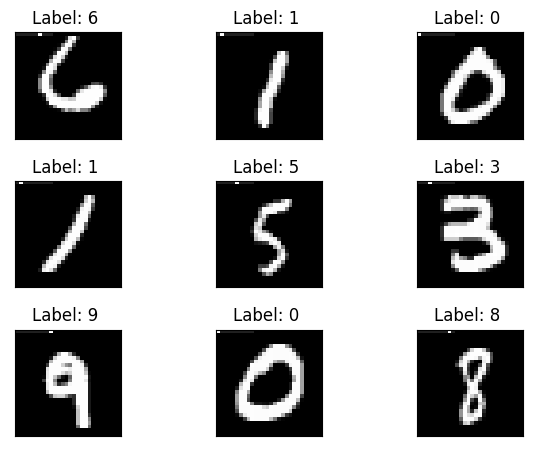

In [22]:
x, y = next(iter(test_dataloader))
# The following line is added to show how overlay_labels_on_data changes the data.
x = overlay_labels_on_data(x, y, num_classes)
display_data(x, labels=y)

In [23]:
class FFLinear(nn.Linear):
    def __init__(
        self, 
        in_features, 
        out_features,
        bias=True, 
        device=None, 
        dtype=None
    ):
        super().__init__(in_features, out_features, bias, device, dtype)
        
        # Nonlinearity (clips negative values).
        self.relu = nn.ReLU()
        # Threshold for differentiating positive and negative labels.
        self.threshold = 2.0
        # Rraining parameters.
        self.opt = torch.optim.Adam(self.parameters(), lr=0.03)
        
    def forward(self, x):
        """
        Compute activations
        """
        # To allow the current layer to learn distinctive features from the previous layers,
        # the incoming data has to be normalized by the length and consider orientation only (Section 2.1).
        # Normalization is applied first so that the layer output directly for prediction.
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        
        return self.relu(
            torch.mm(x_direction, self.weight.T) +
            self.bias.unsqueeze(0)
        )
    
    def train(self, x_pos, x_neg, num_epcohs):
        """
        Update layer weight; The aim of the learning is to make the goodness be
        well above threshold for positive data and 
        well below threshold for negative data (Section 2).
        """
        for i in tqdm(range(num_epochs)):
            g_pos = self.forward(x_pos).pow(2).mean(1)
            g_neg = self.forward(x_neg).pow(2).mean(1)
            # The following loss pushes pos (neg) samples to values larger (smaller) than the self.threshold.
            loss = torch.log(1 + torch.exp(torch.cat([
                -g_pos + self.threshold,
                g_neg - self.threshold]))).mean()
            self.opt.zero_grad()
            # The following backward call ONLY compute gradients for the current layer.
            loss.backward()
            self.opt.step()
        # Since forward-forward algorithm trains layer by layer,
        # train funtion returns the activations of the current layer after updating its weights.
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

In [24]:
class FFNet(nn.Module):
    def __init__(self, dims, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.layers = []
        for d in range(len(dims) - 1):
            self.layers += [FFLinear(dims[d], dims[d + 1], device=device)]

    def predict(self, x, num_layers_to_ignore = 1):
        """
        After training with FF, it is possible to classify a test digit by doing a single forward pass through 
        the net starting from an input that consists of the test digit (Section 3.3).
        """
        goodness_per_label = []
        for label in range(num_classes):
            h = overlay_labels_on_data(x, label, self.num_classes)
            goodness = []
            for layer_idx, layer in enumerate(self.layers):
                h = layer(h)
                # The hidden activities in all but the first hidden layer are then used 
                # as the inputs to a softmax that has been learned during training (Section 3.3).
                if layer_idx < num_layers_to_ignore:
                    continue  
                # The length is used to define the goodness for that layer (Section 2.1).
                goodness += [h.pow(2).mean(1)]
            goodness_per_label += [sum(goodness).unsqueeze(1)]
        goodness_per_label = torch.cat(goodness_per_label, 1)
        # The label with the highest accumulated goodness is chosen.
        return goodness_per_label.argmax(1)

    def train(self, x_pos, x_neg, num_epochs):
        """
        Train the network using forward-forward algorithm (layer by layer).
        """
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            print(f'Training layer {i}')
            h_pos, h_neg = layer.train(h_pos, h_neg, num_epochs)

In [25]:
# The original paper achieves 1.36% test errors only with 60 epochs 
# using a network with 4 hidden layers each containing 2000 ReLUs (Section 3.3).
# In this implementation, the network has two layers of 200 units and trained for 1000 epochs
net = FFNet([image_width * image_height, 200, 200], num_classes)
num_epochs = 1000

x_pos_raw, y_pos = next(iter(train_dataloader))
x_pos_raw, y_pos = x_pos_raw.to(device), y_pos.to(device)
x_pos = overlay_labels_on_data(x_pos_raw, y_pos, num_classes)

# Image data and the label need to be misaligned for the negative samples.
perm = torch.randperm(len(y_pos))
x_neg = overlay_labels_on_data(x_pos_raw, y_pos[perm], num_classes)
net.train(x_pos, x_neg, num_epochs)

train_acc = net.predict(x_pos).eq(y_pos).float().mean().item()
print(f"train acc: {train_acc:.4f} (error: {1-train_acc:.4f})")

Training layer 0


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [09:39<00:00,  5.79s/it]


Training layer 1


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [14:06<00:00,  8.46s/it]


Training layer 2


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [13:57<00:00,  8.38s/it]


Training layer 3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [13:59<00:00,  8.40s/it]


train acc: 0.0236 (error: 0.9764)


In [26]:
x_test, y_test = next(iter(test_dataloader))
x_test, y_test = x_test.to(device), y_test.to(device)
y_pred = net.predict(x_test)
test_acc = y_pred.eq(y_test).float().mean().item()
print(f"test acc: {test_acc:.4f} (error: {1-test_acc:.4f})")

test acc: 0.0277 (error: 0.9723)


test acc: 0.9130 (error: 0.0870)


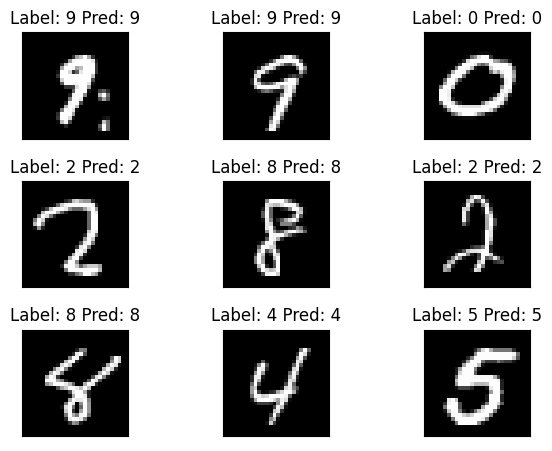

In [35]:
display_data(x_test, y_test, y_pred)

In [28]:
# A network with 4 hidden layers each containing 2000 ReLUs 
# and full connectivity between layers gets 1.36% test errors on MNIST after 60 epochs (Section 3.3).
# net = FFNet([image_width * image_height, 2000, 2000, 2000, 2000], num_classes)
# num_epochs = 60

net = FFNet([image_width * image_height, 250, 250], num_classes)
num_epochs = 1000


x_pos_raw, y_pos = next(iter(train_dataloader))
x_pos_raw, y_pos = x_pos_raw.to(device), y_pos.to(device)
x_pos = overlay_labels_on_data(x_pos_raw, y_pos, num_classes)

# Image data and the label need to be misaligned for the negative samples.
perm = torch.randperm(len(y_pos))
x_neg = overlay_labels_on_data(x_pos_raw, y_pos[perm], num_classes)
net.train(x_pos, x_neg, num_epochs)

train_acc = net.predict(x_pos).eq(y_pos).float().mean().item()
print(f"train acc: {train_acc:.4f} (error: {1-train_acc:.4f})")

x_test, y_test = next(iter(test_dataloader))
x_test, y_test = x_test.to(device), y_test.to(device)
y_pred = net.predict(x_test)
test_acc = y_pred.eq(y_test).float().mean().item()
print(f"test acc: {test_acc:.4f} (error: {1-test_acc:.4f})")

Training layer 0


 28%|██████████████████████▋                                                          | 28/100 [01:54<04:53,  4.07s/it]

KeyboardInterrupt



In [ ]:
# A network with 4 hidden layers each containing 2000 ReLUs 
# and full connectivity between layers gets 1.36% test errors on MNIST after 60 epochs (Section 3.3).
# net = FFNet([image_width * image_height, 2000, 2000, 2000, 2000], num_classes)
# num_epochs = 60

net = FFNet([image_width * image_height, 100, 100], num_classes)
num_epochs = 1000


x_pos_raw, y_pos = next(iter(train_dataloader))
x_pos_raw, y_pos = x_pos_raw.to(device), y_pos.to(device)
x_pos = overlay_labels_on_data(x_pos_raw, y_pos, num_classes)

# Image data and the label need to be misaligned for the negative samples.
perm = torch.randperm(len(y_pos))
x_neg = overlay_labels_on_data(x_pos_raw, y_pos[perm], num_classes)
net.train(x_pos, x_neg, num_epochs)

train_acc = net.predict(x_pos).eq(y_pos).float().mean().item()
print(f"train acc: {train_acc:.4f} (error: {1-train_acc:.4f})")

x_test, y_test = next(iter(test_dataloader))
x_test, y_test = x_test.to(device), y_test.to(device)
y_pred = net.predict(x_test)
test_acc = y_pred.eq(y_test).float().mean().item()
print(f"test acc: {test_acc:.4f} (error: {1-test_acc:.4f})")

In [29]:
# A network with 4 hidden layers each containing 2000 ReLUs 
# and full connectivity between layers gets 1.36% test errors on MNIST after 60 epochs (Section 3.3).
# net = FFNet([image_width * image_height, 2000, 2000, 2000, 2000], num_classes)
# num_epochs = 60

net = FFNet([image_width * image_height, 250, 250], num_classes)
num_epochs = 500


x_pos_raw, y_pos = next(iter(train_dataloader))
x_pos_raw, y_pos = x_pos_raw.to(device), y_pos.to(device)
x_pos = overlay_labels_on_data(x_pos_raw, y_pos, num_classes)

# Image data and the label need to be misaligned for the negative samples.
perm = torch.randperm(len(y_pos))
x_neg = overlay_labels_on_data(x_pos_raw, y_pos[perm], num_classes)
net.train(x_pos, x_neg, num_epochs)

train_acc = net.predict(x_pos).eq(y_pos).float().mean().item()
print(f"train acc: {train_acc:.4f} (error: {1-train_acc:.4f})")

x_test, y_test = next(iter(test_dataloader))
x_test, y_test = x_test.to(device), y_test.to(device)
y_pred = net.predict(x_test)
test_acc = y_pred.eq(y_test).float().mean().item()
print(f"test acc: {test_acc:.4f} (error: {1-test_acc:.4f})")

Training layer 0


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [08:18<00:00,  1.00it/s]


Training layer 1


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [03:54<00:00,  2.13it/s]


train acc: 0.8412 (error: 0.1588)
test acc: 0.8452 (error: 0.1548)


In [30]:
# A network with 4 hidden layers each containing 2000 ReLUs 
# and full connectivity between layers gets 1.36% test errors on MNIST after 60 epochs (Section 3.3).
# net = FFNet([image_width * image_height, 2000, 2000, 2000, 2000], num_classes)
# num_epochs = 60

net = FFNet([image_width * image_height, 100, 100], num_classes)
num_epochs = 1000


x_pos_raw, y_pos = next(iter(train_dataloader))
x_pos_raw, y_pos = x_pos_raw.to(device), y_pos.to(device)
x_pos = overlay_labels_on_data(x_pos_raw, y_pos, num_classes)

# Image data and the label need to be misaligned for the negative samples.
perm = torch.randperm(len(y_pos))
x_neg = overlay_labels_on_data(x_pos_raw, y_pos[perm], num_classes)
net.train(x_pos, x_neg, num_epochs)

train_acc = net.predict(x_pos).eq(y_pos).float().mean().item()
print(f"train acc: {train_acc:.4f} (error: {1-train_acc:.4f})")

x_test, y_test = next(iter(test_dataloader))
x_test, y_test = x_test.to(device), y_test.to(device)
y_pred = net.predict(x_test)
test_acc = y_pred.eq(y_test).float().mean().item()
print(f"test acc: {test_acc:.4f} (error: {1-test_acc:.4f})")

Training layer 0


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:49<00:00,  1.89it/s]


Training layer 1


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:25<00:00,  6.89it/s]


train acc: 0.9010 (error: 0.0990)
test acc: 0.9016 (error: 0.0984)


In [32]:
# A network with 4 hidden layers each containing 2000 ReLUs 
# and full connectivity between layers gets 1.36% test errors on MNIST after 60 epochs (Section 3.3).
# net = FFNet([image_width * image_height, 2000, 2000, 2000, 2000], num_classes)
# num_epochs = 60

net = FFNet([image_width * image_height, 200, 200], num_classes)
num_epochs = 1000


x_pos_raw, y_pos = next(iter(train_dataloader))
x_pos_raw, y_pos = x_pos_raw.to(device), y_pos.to(device)
x_pos = overlay_labels_on_data(x_pos_raw, y_pos, num_classes)

# Image data and the label need to be misaligned for the negative samples.
perm = torch.randperm(len(y_pos))
x_neg = overlay_labels_on_data(x_pos_raw, y_pos[perm], num_classes)
net.train(x_pos, x_neg, num_epochs)

train_acc = net.predict(x_pos).eq(y_pos).float().mean().item()
print(f"train acc: {train_acc:.4f} (error: {1-train_acc:.4f})")

x_test, y_test = next(iter(test_dataloader))
x_test, y_test = x_test.to(device), y_test.to(device)
y_pred = net.predict(x_test)
test_acc = y_pred.eq(y_test).float().mean().item()
print(f"test acc: {test_acc:.4f} (error: {1-test_acc:.4f})")

Training layer 0


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [13:29<00:00,  1.24it/s]


Training layer 1


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:27<00:00,  3.06it/s]


train acc: 0.9093 (error: 0.0907)
test acc: 0.9130 (error: 0.0870)
